<a href="https://colab.research.google.com/github/Jaime-Simoes/NEL_Project/blob/main/NEL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv("data_project_nel.csv")
y_fat = pd.read_csv("y_fat.csv")
y_lactose = pd.read_csv("y_lactose.csv")
y_protein = pd.read_csv("y_protein.csv")

In [3]:
data.head()
# target variables are "fat_percent", "lactose_percent", "protein_percent"

,lactation,delivery_age_years,dim,dry_days,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg
0,7,7.750000,414,56.0,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,0.077973,0.0
1,8,9.083333,357,78.0,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,0.014157,0.0
2,6,7.666667,315,69.0,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,0.045213,12.8
3,7,8.666667,362,69.0,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,0.061713,16.2
4,5,6.500000,427,58.0,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,0.444858,20.2


In [4]:
data.shape

(324, 14)

In [5]:
y_fat.head()

,fat_percent
0,3.787156
1,3.645519
2,3.458251
3,3.407140
4,4.902554


In [6]:
y_fat.shape

(324, 1)

In [7]:
y_lactose.head()

,lactose_percent
0,4.953503
1,4.983128
2,4.889104
3,4.868969
4,4.845402


In [8]:
y_lactose.shape

(324, 1)

In [9]:
y_protein.head()

,protein_percent
0,3.511685
1,3.470806
2,3.370124
3,3.221164
4,3.395152


In [10]:
y_protein.shape

(324, 1)

In [11]:
# Ok the sizes match up.
# Let's join everything

In [12]:
data = pd.concat([data, y_lactose, y_fat, y_protein], axis=1)

In [13]:
data.head()

,lactation,delivery_age_years,dim,dry_days,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg,lactose_percent,fat_percent,protein_percent
0,7,7.750000,414,56.0,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,0.077973,0.0,4.953503,3.787156,3.511685
1,8,9.083333,357,78.0,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,0.014157,0.0,4.983128,3.645519,3.470806
2,6,7.666667,315,69.0,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,0.045213,12.8,4.889104,3.458251,3.370124
3,7,8.666667,362,69.0,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,0.061713,16.2,4.868969,3.407140,3.221164
4,5,6.500000,427,58.0,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,0.444858,20.2,4.845402,4.902554,3.395152


In [14]:
data.isnull().sum()
# almost half of "dry_days" are missing values. Should we delete? Or maybe it has some meaning?

lactation                     0
delivery_age_years            0
dim                           0
dry_days                    147
forage_kg_day                 0
rumination_min_day            0
milk_kg_day                   0
milk_kg_min_robot             0
milkings_day                  0
errors_by_100_milkings        0
high_cdt_by_100_milkings      0
watery_by_100_milkings        0
refusals_by_milking           0
colostrum_separated_kg        0
lactose_percent               0
fat_percent                   0
protein_percent               0
dtype: int64

In [15]:
data.describe()
# check with the dictionary to see if values make sense (especially min and max)
# "milk_kg_min_robot" -> don't really understand what this means

# but the values seem to make sense, not a lot of pre processing going on

,lactation,delivery_age_years,dim,dry_days,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg,lactose_percent,fat_percent,protein_percent
count,324.000000,324.000000,324.000000,177.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000
mean,2.055556,3.040895,327.617284,65.440678,4.657507,527.641508,39.585367,2.806910,2.969289,1.746837,0.202839,0.067426,0.257540,11.773148,4.892862,3.725701,3.332415
std,1.320240,1.432558,46.261491,9.349777,0.585053,53.863379,6.698681,0.839749,0.552387,3.505659,1.045158,0.381647,0.248818,15.401783,0.064497,0.553990,0.149771
min,1.000000,1.666667,249.000000,22.000000,2.887079,316.874074,15.355600,0.951521,2.016340,0.000000,0.000000,0.000000,0.003241,0.000000,4.707464,2.360311,2.691201
25%,1.000000,1.916667,296.000000,61.000000,4.318435,490.580690,34.709342,2.147157,2.529756,0.152436,0.000000,0.000000,0.084442,0.000000,4.847754,3.358378,3.246586
50%,2.000000,2.750000,313.500000,66.000000,4.672403,537.830980,39.510841,2.787723,2.940860,0.786993,0.000000,0.000000,0.187785,5.800000,4.890983,3.681142,3.347080
75%,3.000000,3.750000,346.250000,70.000000,5.012795,566.156378,43.973411,3.344835,3.391920,1.582636,0.000000,0.000000,0.346494,20.200000,4.932776,4.088429,3.430267
max,8.000000,9.083333,590.000000,112.000000,6.340225,638.546053,59.722312,5.526386,5.024390,36.382323,13.333333,3.826955,1.520631,82.500000,5.058967,5.183688,3.682320


In [16]:
# Now follow those two codes from practical 2 and adapt to this, then put some more things. But dataset looks easy to work with

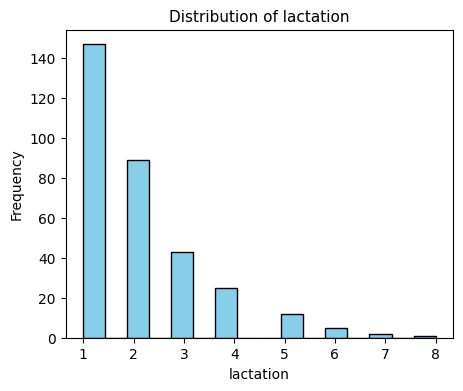

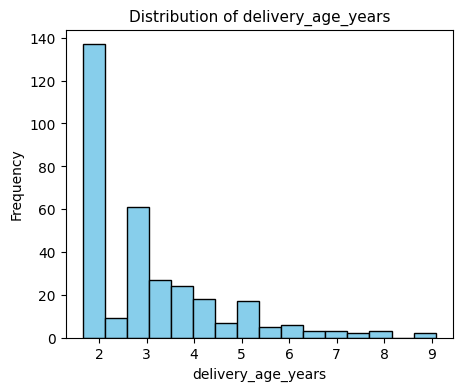

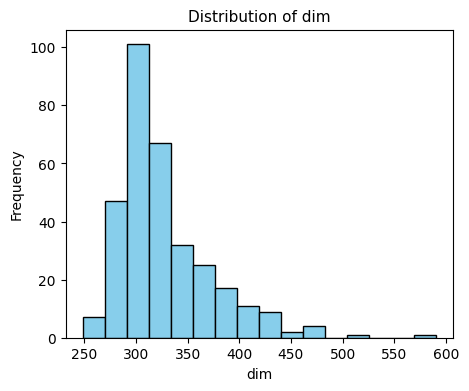

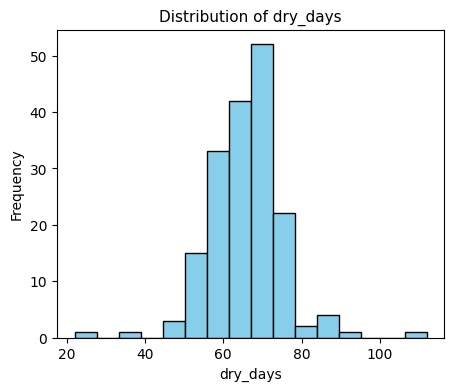

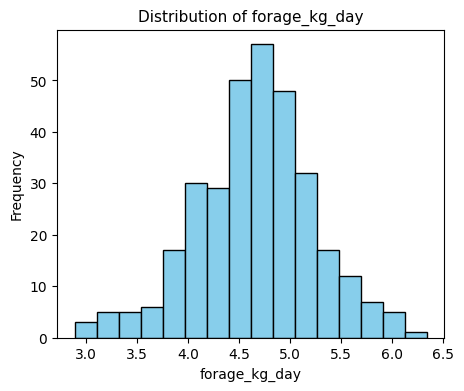

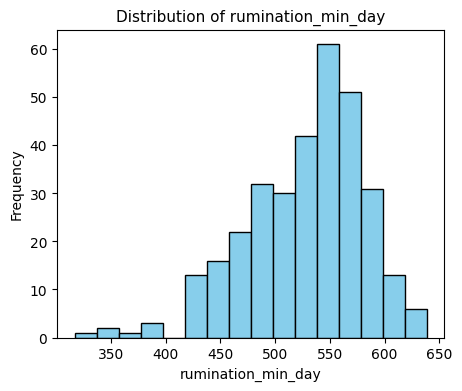

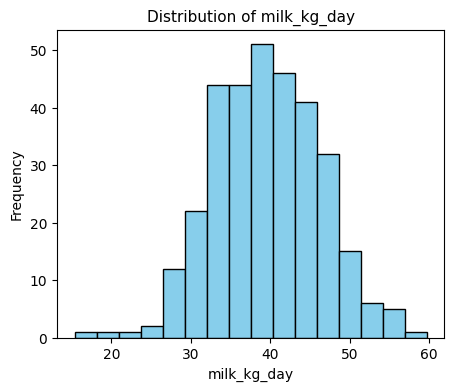

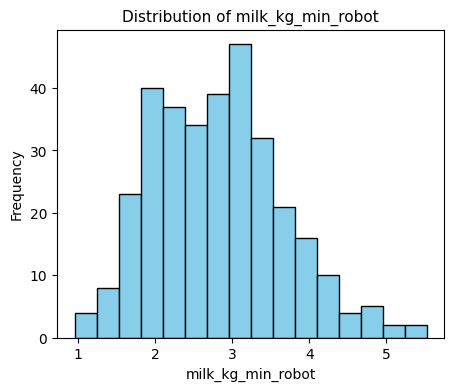

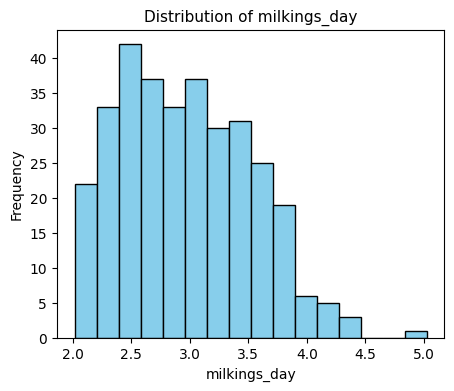

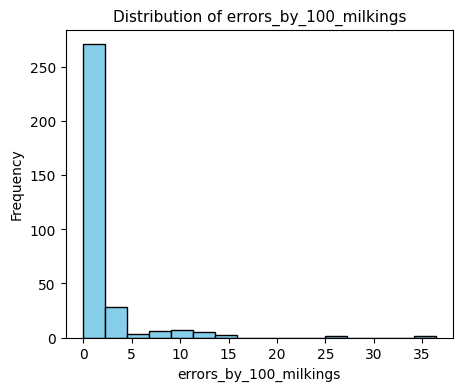

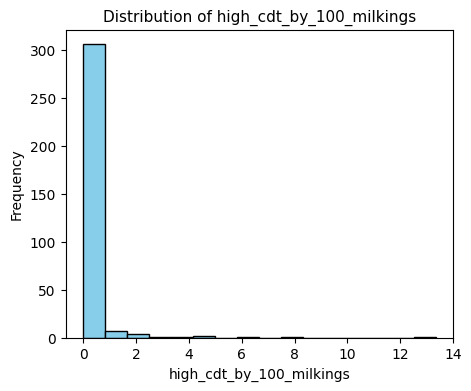

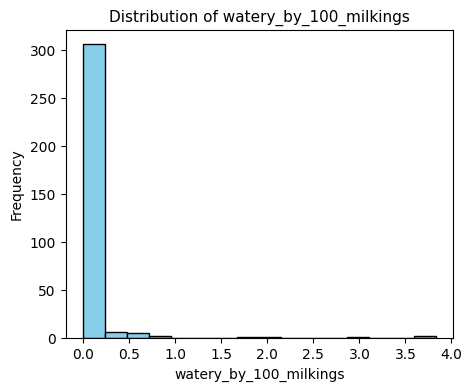

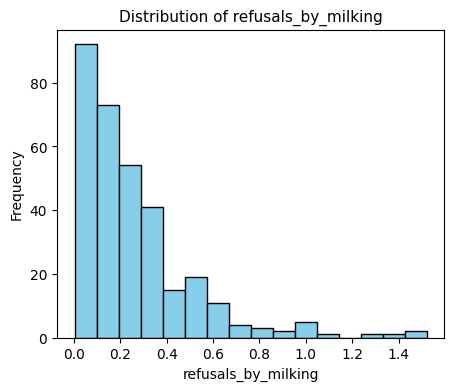

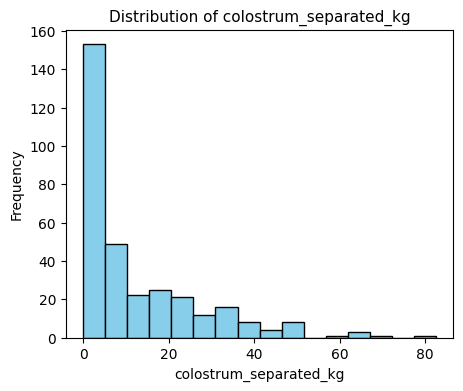

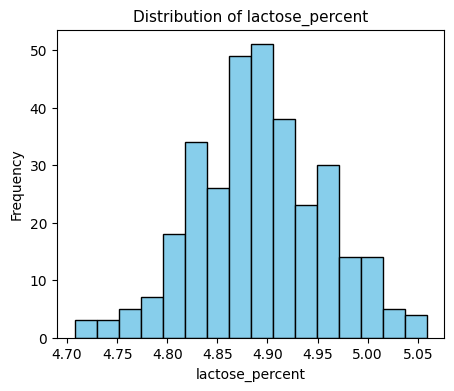

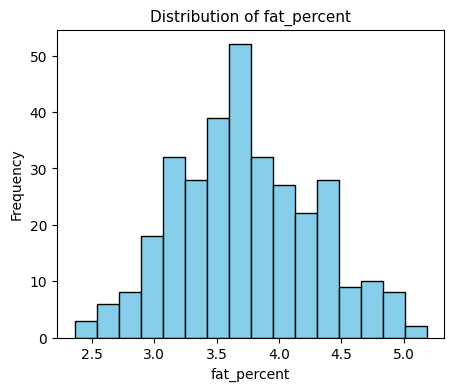

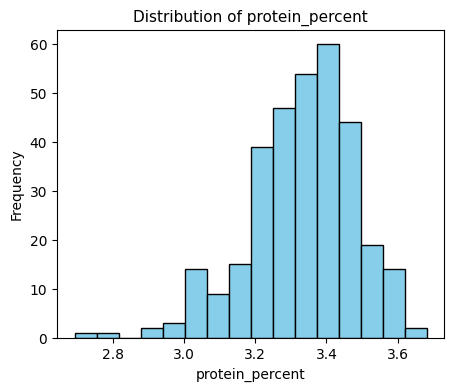

In [22]:
for column in data.columns:

    plt.figure(figsize=(5, 4))
    data[column].plot(kind='hist', bins=16, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {column}', fontsize=11)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Last three are the target variables

In [ ]:
# Let's normalize the data:

In [24]:
scaler = MinMaxScaler()
data_norm = scaler.fit_transform(data)
data_norm = pd.DataFrame(data_norm, columns=data.columns)

In [25]:
data_norm.head()

,lactation,delivery_age_years,dim,dry_days,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg,lactose_percent,fat_percent,protein_percent
0,0.857143,0.820225,0.483871,0.377778,0.412331,0.366647,0.422090,0.599838,0.153562,0.056258,0.0,0.000000,0.049250,0.000000,0.699962,0.505368,0.827836
1,1.000000,1.000000,0.316716,0.622222,0.370679,0.847528,0.469164,0.671636,0.053234,0.024762,0.0,0.000000,0.007194,0.000000,0.784245,0.455203,0.786590
2,0.714286,0.808989,0.193548,0.522222,0.583889,0.701658,0.631468,0.385526,0.123323,0.029240,0.0,0.034748,0.027660,0.155152,0.516753,0.388875,0.685006
3,0.857143,0.943820,0.331378,0.522222,0.407641,0.968371,0.593408,0.389470,0.058852,0.048464,0.0,0.000000,0.038534,0.196364,0.459470,0.370772,0.534712
4,0.571429,0.651685,0.521994,0.400000,0.553565,0.505049,0.508507,0.204834,0.374501,0.020481,0.0,0.000000,0.291037,0.244848,0.392424,0.900426,0.710259
